In [1]:
# Imports
import torch
import torch.nn.functional as F

import numpy as np

import sys
sys.path.append("../models/")

# Add the upper directory to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet
sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

torch.cuda.empty_cache()
device = torch.device("cuda")

In [2]:
# Dataloaders
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size)

In [3]:
# Models
model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../models/vess_map_regularized_none_200.pth"))

model = model.eval()

In [4]:
all_images = []


# Iterate through the entire train_loader
for batch in train_loader:
    images, _, _ = batch
    images = images.to(device)
    all_images.extend(images)
    
for batch in test_loader:
    images, _, _ = batch
    images = images.to(device)
    all_images.extend(images)

In [5]:
def compute_softmax_gradient(model, image, x_pixel, y_pixel, threshold_proportion):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Apply softmax to the output to get class probabilities
    probabilities = F.softmax(out, dim=1)

    score = probabilities[0, 1, x_pixel, y_pixel]  # Probability of class 1 at (x, y)

    # Compute gradients
    score.backward()

    gradient = image.grad.squeeze().cpu().numpy()
    # Return the gradient
    threshold = np.max(gradient) * threshold_proportion
    mask = np.abs(gradient) > threshold
    non_zero_coords = np.nonzero(mask)
    
    if len(non_zero_coords[0]) > 0:
        y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
        x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
        num_pixels_above_threshold = np.sum(mask)
        bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
        #fulfillment = num_pixels_above_threshold / bounding_box_area
        return bounding_box_area
    return 0

In [6]:
def get_all_gradients(model, image, sampling_rate = 10, device = "cuda", vectorize = False):
  torch.cuda.empty_cache()

  model.to(device)
  image = image.to(device).unsqueeze(0)
  sampled_image = image[:,:,::sampling_rate,::sampling_rate]
  sampled_image.requires_grad = True
  
  jacobian_gradient = torch.autograd.functional.jacobian(model, 
                                                         sampled_image,
                                                         vectorize = vectorize)
  jacobian_gradient = jacobian_gradient.squeeze()
  return jacobian_gradient

In [7]:
def compute_bounding_box_area(model, image, threshold_proportion):
    
    # Dimensions of the original image
    height, width = image.shape[1], image.shape[2]
    # Sampling ratio
    sampling = 1

    jacobian_gradients = get_all_gradients(model, image, sampling_rate = sampling, device = 'cpu')
    
    # Generate arrays of indices for rows and columns
    row_indices = np.arange(0, height, sampling)
    col_indices = np.arange(0, width, sampling)

    # Create a meshgrid of indices
    row_indices, col_indices = np.meshgrid(row_indices, col_indices)

    # Flatten the arrays to get a list of (row, col) pairs
    sampled_pixel_indices = np.vstack([row_indices.flatten(), col_indices.flatten()]).T

    fulfillment_image = np.zeros_like(image.to('cpu'))
    for pixel_coord in sampled_pixel_indices:
        # Return the gradient
        
        gradient = jacobian_gradients[1, int(pixel_coord[0] / 10), int(pixel_coord[1] / 10)]
        
        threshold = np.max(gradient.detach().cpu().numpy()) * threshold_proportion
        mask = np.abs(gradient.detach().cpu().numpy()) > threshold
        non_zero_coords = np.nonzero(mask)
        
        if len(non_zero_coords[0]) > 0:
            y_min, y_max = non_zero_coords[0].min(), non_zero_coords[0].max()
            x_min, x_max = non_zero_coords[1].min(), non_zero_coords[1].max()
            num_pixels_above_threshold = np.sum(mask)
            bounding_box_area = (y_max - y_min + 1) * (x_max - x_min + 1)
            #fulfillment = num_pixels_above_threshold / bounding_box_area
            fulfillment_image[0, pixel_coord[0], pixel_coord[1]] = bounding_box_area
        
    return fulfillment_image

In [8]:
threshold_proportion = 0.1
fulfillment_image = np.zeros_like(all_images[0].to('cpu'))  # Initialize the fulfillment image
fulfillment_images = []
for input_image in all_images[:1]:
    fulfillment_image = compute_bounding_box_area(model, input_image, threshold_proportion)

    # Normalize the fulfillment image to the range [0, 1]
    fulfillment_image = (fulfillment_image - np.min(fulfillment_image)) / (np.max(fulfillment_image) - np.min(fulfillment_image))

    fulfillment_images.append(fulfillment_image)

KeyboardInterrupt: 

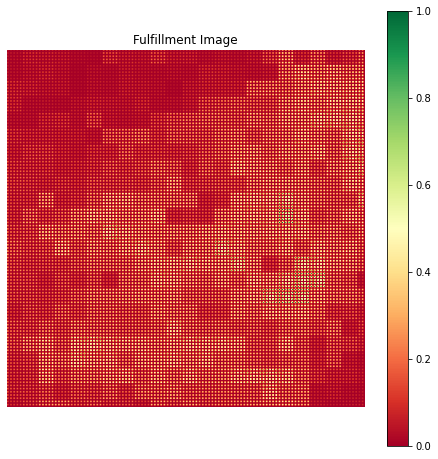

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(fulfillment_images[0].transpose(1, 2, 0), cmap='RdYlGn')  
plt.colorbar()
plt.title('Fulfillment Image')
plt.axis('off')
plt.show()